In [1]:
%pylab inline
import time

Populating the interactive namespace from numpy and matplotlib


In [2]:
#
# Cleveland and McGill: Graphical Perception, 1984
# Figure 12
#
# Weber's Law: differences in encoded numerical quantities
#

In [3]:
def create_rectangles(framed=False, size=(100,100)):
    '''
    '''
    image, A_y, B_y, A_height, B_height = draw_rectangles(framed, size)

    while (np.abs(A_y - B_y) < 10) or (np.abs(A_height - B_height) < 1):
        image, A_y, B_y, A_height, B_height = draw_rectangles(framed, size)        
    
    if A_height > B_height:
        label = 0
    elif A_height < B_height:
        label = 1
    
    return image, label
    

def draw_rectangles(framed, size):
    '''
    '''
    image = np.zeros(size, dtype=np.int8)
    
    max_height = 65
    delta = 5
    width = 20
    
    A_x = 20
    A_y = np.random.randint(size[0] - max_height)
    A_height = np.random.randint(max_height-delta, max_height)
    image[A_y:A_y+max_height,A_x:A_x+1] = 2
    image[A_y:A_y+max_height,A_x+width:A_x+width+1] = 2
    image[A_y:A_y+1,A_x:A_x+width] = 2
    image[A_y+max_height:A_y+max_height+1,A_x:A_x+width+1] = 2
    image[A_y+max_height-A_height:A_y+max_height+1,A_x:A_x+width+1] = 1
    
    B_x = 60
    B_y = np.random.randint(size[0] - max_height)
    B_height = np.random.randint(max_height-delta, max_height)
    image[B_y:B_y+max_height,B_x:B_x+1] = 2
    image[B_y:B_y+max_height,B_x+width:B_x+width+1] = 2
    image[B_y:B_y+1,B_x:B_x+width] = 2
    image[B_y+max_height:B_y+max_height+1,B_x:B_x+width+1] = 2    
    image[B_y+max_height-B_height:B_y+max_height+1,B_x:B_x+width+1] = 1    
    
    if not framed:
        image[image == 2] = 0
    
    return image, A_y, B_y, A_height, B_height


In [4]:
#
# let's create a bunch of samples
#
N = 100000

t0 = time.time()

images = np.zeros((N, 100, 100), dtype=np.bool)
framed_images = np.zeros((N, 100, 100), dtype=np.bool)
labels = np.zeros((N), dtype=np.bool)

for n in range(N):
    
    framed_image, label = create_rectangles(True) # create framed image
    # remove frame
    image = framed_image.copy()
    image[image == 2] = 0
    images[n] = image.astype(np.bool)
    
    # harden frame
    framed_image[framed_image == 2] = 1
    framed_images[n] = framed_image.astype(np.bool)
    
    labels[n] = label
    
print 'Done after', time.time()-t0, 'seconds'
print 'Label 0', len(np.where(labels == 0)[0])
print 'Label 1', len(np.where(labels == 1)[0])

Done after 10.7353830338 seconds
Label 0 49853
Label 1 50147


LABEL 0


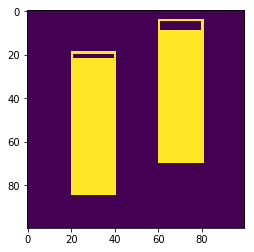

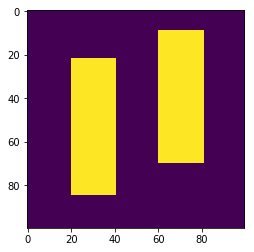

In [5]:
INDEX = 2
imshow(framed_images[INDEX])
plt.figure()
imshow(images[INDEX])
print 'LABEL', int(labels[INDEX])

In [6]:
#
# BULK EXPERIMENT
#
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import Callback

class TestCallback(Callback):
    def __init__(self, test_data):
        self.test_data = test_data
        self.test_losses = []
        self.test_accs = []

    def on_epoch_end(self, epoch, logs={}):
        x, y = self.test_data
        test_loss, test_acc = self.model.evaluate(x, y, verbose=0)
        self.test_losses.append(test_loss)
        self.test_accs.append(test_acc)


def run_bulk(data, labels, epochs=10, repeats=10):

    # since we shuffle in-place, copy data and labels
    data = data.copy()
    labels = labels.copy()
    
    stats = []
    for r in range(repeats):

        # shuffle the data
#         indices = numpy.random.permutation(len(labels))
#         shuffled_data = data[indices]
#         shuffled_labels = labels[indices]
        rng_state = numpy.random.get_state()
        numpy.random.shuffle(data)
        numpy.random.set_state(rng_state)
        numpy.random.shuffle(labels)
        shuffled_data = data
        shuffled_labels = labels
    
        model = Sequential()
        model.add(Dense(12, input_dim=100*100, activation='relu'))
        model.add(Dense(8, activation='relu'))
        model.add(Dense(1, activation='sigmoid'))

        sgd = optimizers.SGD(lr=0.0001, decay=1e-6, momentum=0.9, nesterov=True)
        model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])

        test_callback = TestCallback((shuffled_data[80000:].reshape(20000,100*100), shuffled_labels[80000:]))
        
        history = model.fit(shuffled_data[0:80000].reshape(80000,100*100), shuffled_labels[0:80000], \
                            epochs=epochs, validation_split=0.25, verbose=False, \
                            callbacks=[test_callback])
        test_results_after_training = model.evaluate(shuffled_data[80000:].reshape(20000,100*100), \
                                                     shuffled_labels[80000:])

        test_results_after_each_epoch = (test_callback.test_losses, test_callback.test_accs)
                
        stats.append((history.history, test_results_after_training, test_results_after_each_epoch))
        
        
    return stats
        

Using TensorFlow backend.


In [36]:
def plot_training_loss(stats):
    
    train_loss = [k[0]['loss'] for k in stats]
    for i,v in enumerate(train_loss):
        plt.plot(v, label='Run '+str(i))
    plt.title('Training Loss per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Training Loss')
    if i <= 10:
        plt.legend()
    
def plot_training_acc(stats):
    
    train_acc = [k[0]['acc'] for k in stats]
    for i,v in enumerate(train_acc):
        plt.plot(v, label='Run '+str(i))
    plt.title('Training Accuracy per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Training Accuracy')
    if i <= 10:
        plt.legend()

def plot_validation_loss(stats):
    
    val_loss = [k[0]['val_loss'] for k in stats]
    for i,v in enumerate(val_loss):
        plt.plot(v, label='Run '+str(i))
    plt.title('Validation Loss per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Val. Loss')
    if i <= 10:
        plt.legend()
    
def plot_validation_acc(stats):
    
    val_acc = [k[0]['val_acc'] for k in stats]
    for i,v in enumerate(val_acc):
        plt.plot(v, label='Run '+str(i))
    plt.title('Validation Accuracy per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Val. Accuracy')
    if i <= 10:
        plt.legend()
    
def plot_test_loss(stats):
    
    test_loss = [k[2][0] for k in stats]
    for i,v in enumerate(test_loss):
        plt.plot(v, label='Run '+str(i))
    plt.title('Test Loss per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Test Loss')
    if i <= 10:
        plt.legend()
    
def plot_test_acc(stats):
    
    test_acc = [k[2][1] for k in stats]
    for i,v in enumerate(test_acc):
        plt.plot(v, label='Run '+str(i))
    plt.title('Test Accuracy per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Test Accuracy')
    if i <= 10:
        plt.legend()
    
def get_average_test_stats(stats, which=0):
    
    mean_loss_per_epoch = []
    
    test_loss = [k[2][which] for k in stats]
    
    for e in range(len(test_loss[0])):
        # looping through epochs
        
        current_loss = 0
        for i,l in enumerate(test_loss):
            current_loss += l[e]
            
        current_loss /= float(len(test_loss))
        mean_loss_per_epoch.append(current_loss)
        
    return mean_loss_per_epoch

def plot_average_test_loss(stats):
    
    mean_loss_per_epoch = get_average_test_stats(stats, 0) # 0 for loss
        
    plt.plot(mean_loss_per_epoch)
    plt.title('Average Test Loss per Epoch for All Runs')
    plt.xlabel('Epoch')
    plt.ylabel('Average Test Loss')
    plt.legend()
    
def plot_average_test_acc(stats):
    
    mean_acc_per_epoch = get_average_test_stats(stats, 1) # 1 for acc
        
    plt.plot(mean_acc_per_epoch)
    plt.title('Average Test Accuracy per Epoch for All Runs')
    plt.xlabel('Epoch')
    plt.ylabel('Average Test Accuracy')
    plt.legend()
    
def plot(stats):
    
    plt.figure()
    plot_training_loss(stats)
    
    plt.figure()
    plot_training_acc(stats)
    
    plt.figure()
    plot_validation_loss(stats)
    
    plt.figure()
    plot_validation_acc(stats)
    
    plt.figure()
    plot_test_loss(stats)
    
    plt.figure()
    plot_test_acc(stats)
    
    plt.figure()
    plot_average_test_loss(stats)
    
    plt.figure()
    plot_average_test_acc(stats)

In [8]:
from pyvttbl import DataFrame
from scipy.stats import ttest_ind, ttest_ind_from_stats

def compare_test_loss(stats, framed_stats):
    
    #
    # PLOTS
    #
    mean_loss_per_epoch = get_average_test_stats(stats, 0) # 0 for loss
    mean_loss_per_epoch_framed = get_average_test_stats(framed_stats, 0) # 0 for loss    
        
    plt.plot(mean_loss_per_epoch, color='blue', label='No Frames')
    plt.plot(mean_loss_per_epoch_framed, color='red', label='Frames')
    plt.title('Average Test Loss per Epoch for All Runs')
    plt.xlabel('Epoch')
    plt.ylabel('Average Test Loss')
    plt.legend()
    
    test_loss = [k[1][0] for k in stats]
    test_loss_framed = [k[1][0] for k in framed_stats]    
    
    plt.figure()
    plt.plot(test_loss, color='blue', label='No Frames')
    plt.plot(test_loss_framed, color='red', label='Frames')
    plt.title('Final Test Loss for All Runs')
    plt.xlabel('Run')
    plt.ylabel('Final Test Loss')
    plt.legend()

    #
    # TESTS (ANOVA + t-Test)
    #
    df = DataFrame()
    df['data'] = test_loss+test_loss_framed

    df['conditions'] = ['No Frames']*len(test_loss) + ['Frames']*len(test_loss_framed)

    anova = df.anova1way('data', 'conditions')
    print anova

    t, p = ttest_ind(test_loss, test_loss_framed, equal_var=False)
    print t, p
    
def compare_test_acc(stats, framed_stats):
    
    #
    # PLOTS
    #
    mean_loss_per_epoch = get_average_test_stats(stats, 1) # 1 for acc
    mean_loss_per_epoch_framed = get_average_test_stats(framed_stats, 1) # 1 for acc    
        
    plt.plot(mean_loss_per_epoch, color='blue', label='No Frames')
    plt.plot(mean_loss_per_epoch_framed, color='red', label='Frames')
    plt.title('Average Test Accuracy per Epoch for All Runs')
    plt.xlabel('Epoch')
    plt.ylabel('Average Test Accuracy')
    plt.legend()


In [42]:
def store_results(stats, framed_stats, output_folder='/home/d/Projects/CP/RESULTS/Cleveland_McGill_Figure_12_BULK_AND_SHUFFLE_TEST_PER_EPOCH_100/'):
    
    import cPickle as pickle
    import os, sys

    if not os.path.exists(outputfolder):
        os.makedirs(outputfolder)

    stats_counter = 0
    stats_path = os.path.join(outputfolder, 'stats_'+str(stats_counter)+'.p')    
    while os.path.exists(stats_path):
        counter += 1
        stats_path = os.path.join(outputfolder, 'stats_'+str(stats_counter)+'.p')
    
    framed_stats_counter = 0
    framed_stats_path = os.path.join(outputfolder, 'framed_stats_'+str(framed_stats_counter)+'.p')    
    while os.path.exists(stats_path):
        counter += 1
        stats_path = os.path.join(outputfolder, 'stats_'+str(framed_stats_counter)+'.p')
    
    with open(stats_path, 'w') as f:
        pickle.dump(stats, f)
        
        print 'Stored', stats_path
        
    with open(framed_stats_path, 'w') as f:
        pickle.dump(framed_stats, f)

        print 'Stored', framed_stats_path
        
        

In [9]:
#
# NN without frames
#
stats = run_bulk(images, \
                 labels, \
                 epochs=10, \
                 repeats=100)

20000/20000 [==============================] - 1s 68us/step


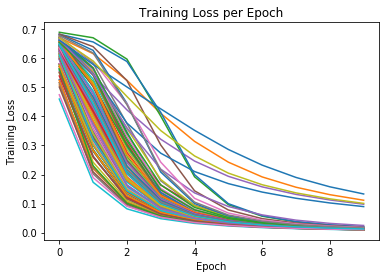

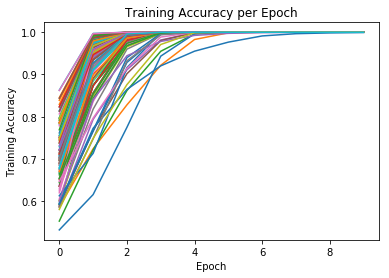

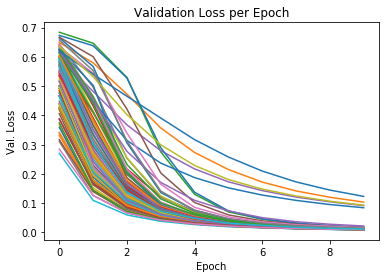

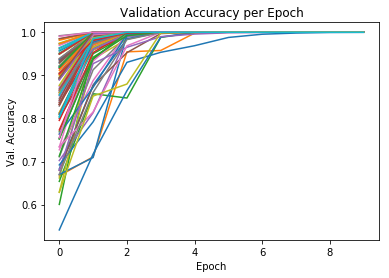

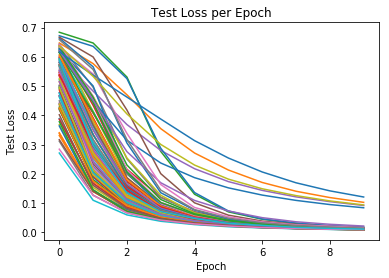

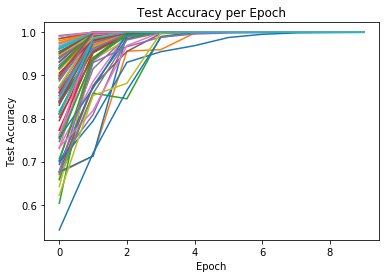

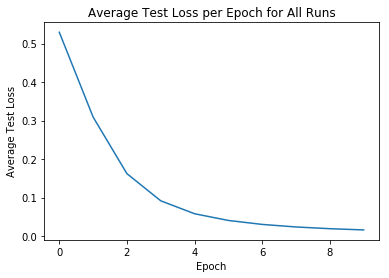

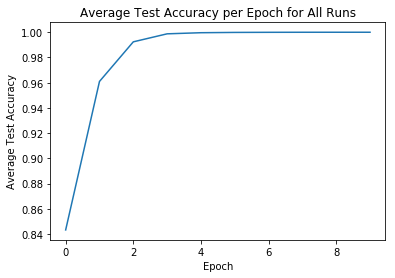

In [21]:
plot(stats)

In [11]:
#
# NN with frames
#
framed_stats = run_bulk(framed_images, \
                        labels, \
                        epochs=10, \
                        repeats=100)

20000/20000 [==============================] - 2s 80us/step


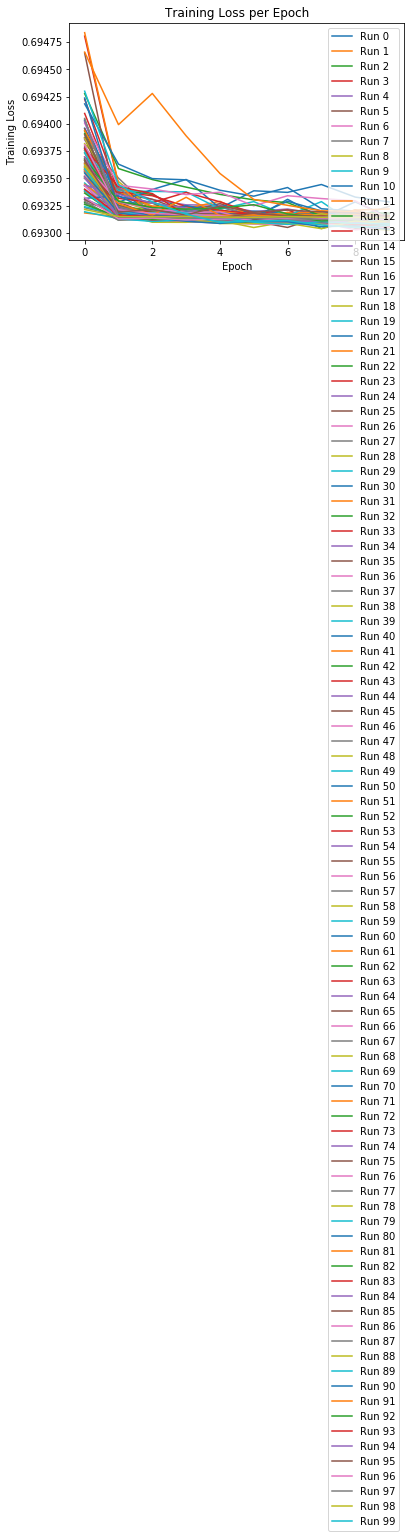

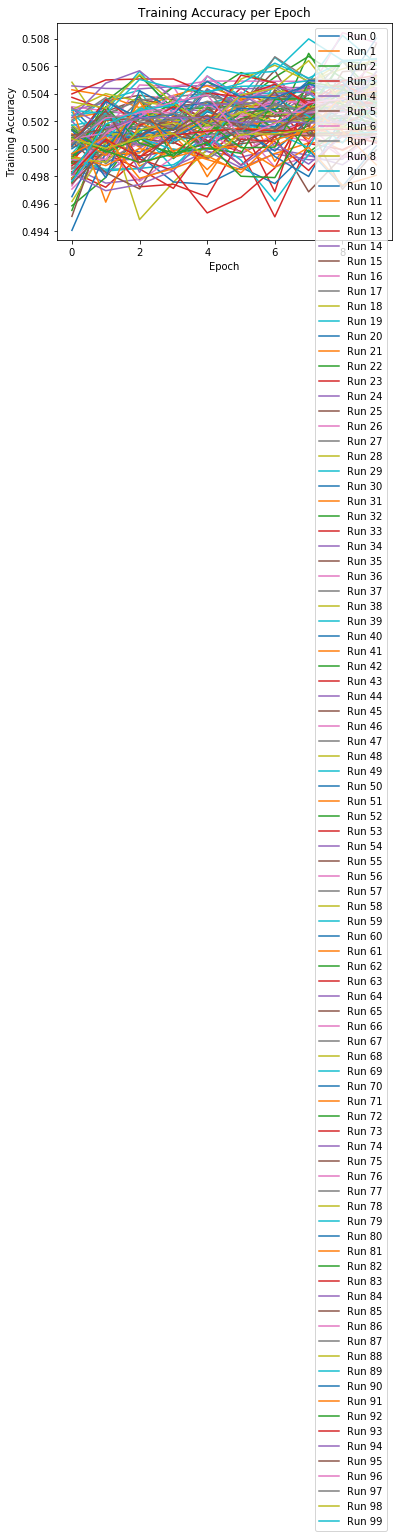

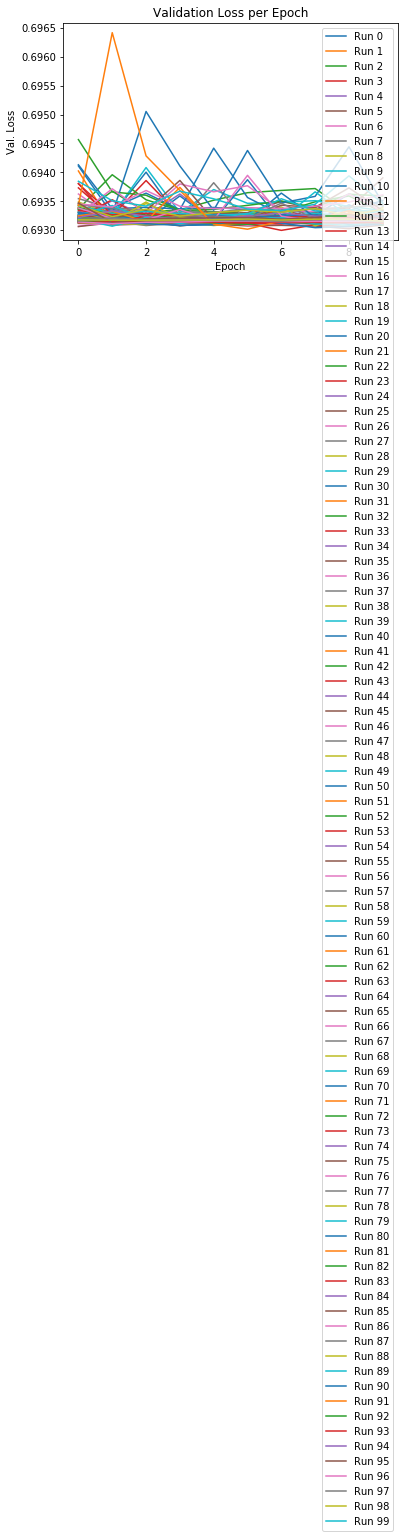

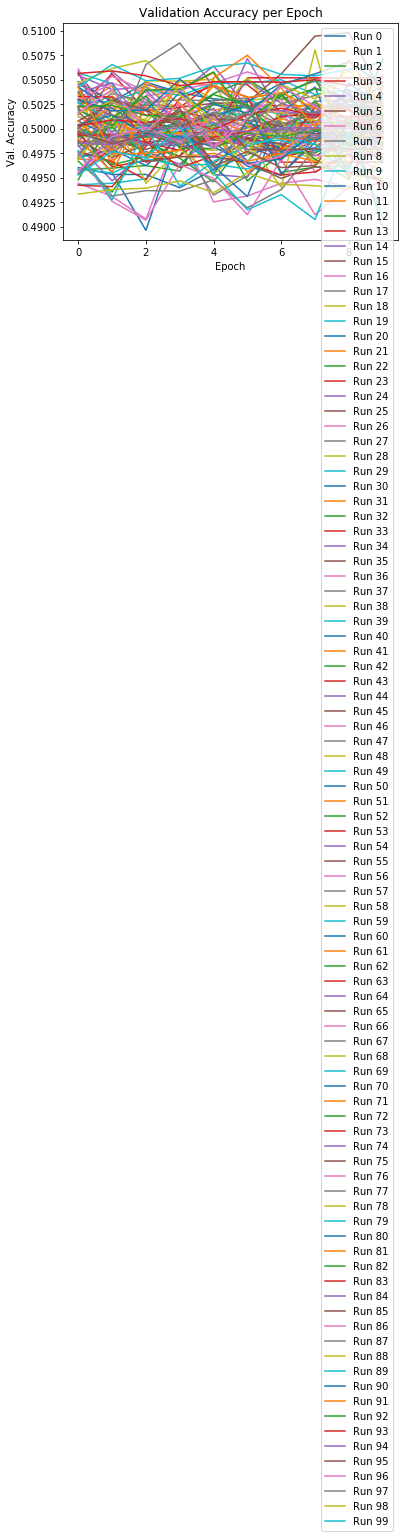

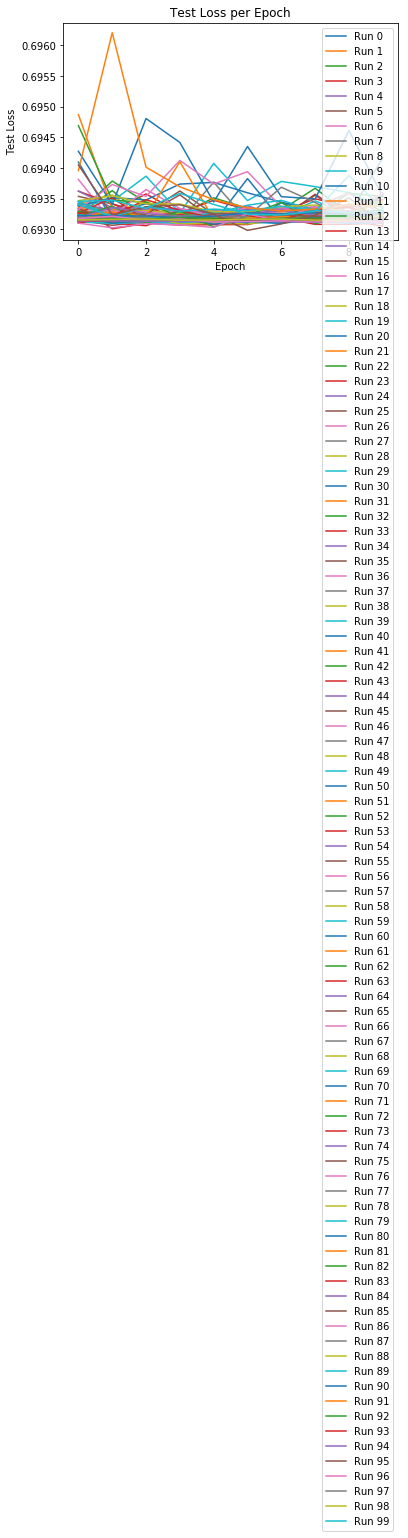

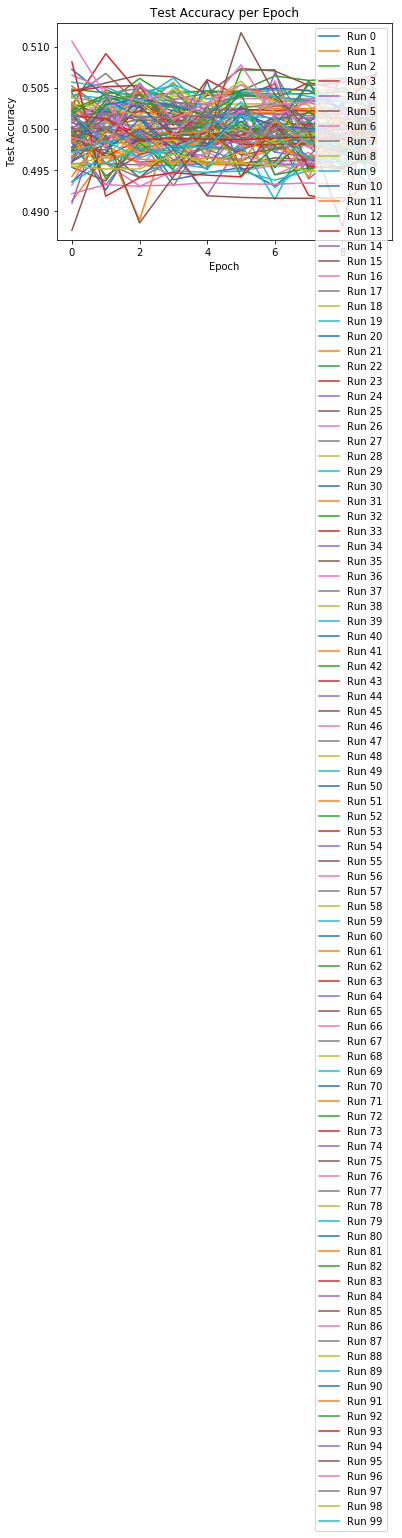

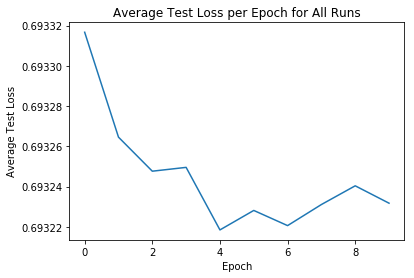

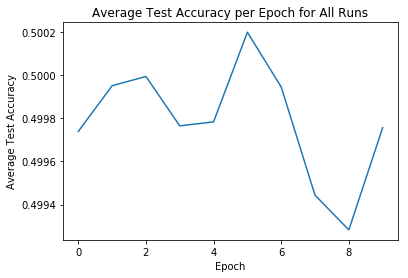

In [12]:
plot(framed_stats)

In [ ]:
store_results(stats, framed_stats)

Anova: Single Factor on data

SUMMARY
 Groups     Count    Sum     Average   Variance  
Frames        100   69.323     0.693   2.212e-08 
No Frames     100    1.597     0.016   3.776e-04 

O'BRIEN TEST FOR HOMOGENEITY OF VARIANCE
Source of Variation      SS       df       MS         F     P-value   eta^2   Obs. power 
Treatments            7.128e-06     1   7.128e-06   5.302     0.022   0.026        0.623 
Error                 2.662e-04   198   1.344e-06                                        
Total                 2.733e-04   199                                                    

ANOVA
Source of Variation     SS     df       MS           F         P-value     eta^2   Obs. power 
Treatments            22.934     1      22.934   121470.815   4.904e-278   0.998            1 
Error                  0.037   198   1.888e-04                                                
Total                 22.971   199                                                            

POSTHOC MULTIPLE COMPA

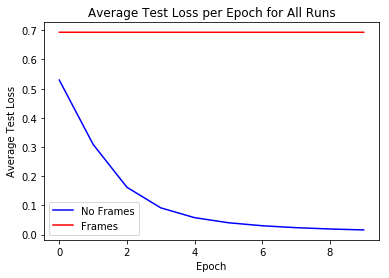

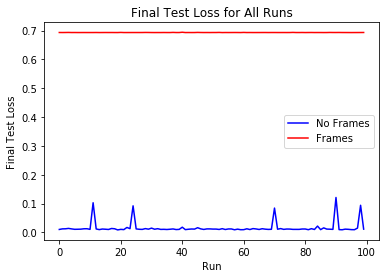

In [13]:
#
# COMPARE!
#
compare_test_loss(stats, framed_stats)

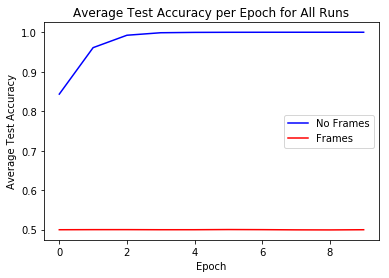

In [14]:
compare_test_acc(stats, framed_stats)